# Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Feger/am-limited-generalizability

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Feger/am-limited-generalizability


In [2]:
! pip install pingouin==0.5.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.1 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import matplotlib.patches as patches
import matplotlib.font_manager as fm
import warnings
from tqdm.notebook import tqdm
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.exceptions import UndefinedMetricWarning
from google.colab import runtime

# Get times font
font_path = "./output/images/times.ttf"

# Load the font in Matplotlib
times_new_roman_font = fm.FontProperties(fname=font_path, size=15)

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore")

WRAP = "TomatenMarc/WRAPresentations"
BERT = "bert-base-uncased"
ROBERTA = "roberta-base"
DISTILBERT = "distilbert-base-uncased"
DTREE = "DTree"
RANDOM = "Random"

model_name_map = {
    WRAP: "WRAP",
    BERT: "BERT",
    ROBERTA: "RoBERTa",
    DISTILBERT: "DistilBERT",
    DTREE: "DTree",
    RANDOM: "Random"
}

In [4]:
def select_model(results, model_name):
    return [result for result in results if result['model'] == model_name]

def get_macro_f1(result):
    return result["test_report"]['macro avg']['f1-score']

def create_model_matrix(data, model):
    data = select_model(data, model)
    # Initialize a DataFrame to hold the best F1-scores for each source-target pair
    sources = sorted(set([d['source'][0] for d in data]))
    targets = sorted(set([d['target'][0] for d in data]))

    # Create a matrix with sources as rows and targets as columns
    model_matrix = pd.DataFrame(index=sources, columns=targets, dtype=float)
    model_matrix.name = model
    for d in data:
        model_name = d['model']
        source = d['source'][0] if len(d['source']) == 1 else d['target'][0] # for leave-one-out
        target = d['target'][0]
        model_matrix.at[source, target] = get_macro_f1(d)

    return model_matrix

def melt_down(df):
    df_melted = df.reset_index().melt(id_vars="index", var_name="column", value_name="value")
    df_melted.rename(columns={"index": "row"}, inplace=True)
    df_melted['pair'] = list(zip(df_melted['row'], df_melted['column']))
    df_melted_final = df_melted[['pair', 'value']]
    return df_melted_final

def long_data(models, results_42, results_51099, results_374318):
    # Initialize an empty list to collect data
    data_list = []

    # Iterate over models and collect results
    for model in models:
        # Create model matrices and melt them down
        f1_42 = melt_down(create_model_matrix(results_42, model))
        f1_51099 = melt_down(create_model_matrix(results_51099, model))
        f1_374318 = melt_down(create_model_matrix(results_374318, model))

        # Ensure 'pair' columns are equal across dataframes
        assert f1_42["pair"].equals(f1_51099["pair"]) and f1_42["pair"].equals(f1_374318["pair"]) and f1_51099["pair"].equals(f1_374318["pair"])

        # Collect results in long format
        df_temp = pd.DataFrame({
            "pair": f1_42["pair"].tolist() * 3,  # Repeat for each seed
            "seed": ["42"] * len(f1_42) + ["51099"] * len(f1_51099) + ["374318"] * len(f1_374318),
            "model": [model] * (len(f1_42) * 3),
            "macro_f1": f1_42["value"].tolist() + f1_51099["value"].tolist() + f1_374318["value"].tolist()
        })

        data_list.append(df_temp)

    # Concatenate all the temporary dataframes into one
    result_df = pd.concat(data_list, ignore_index=True)
    # Convert to categorical
    result_df["seed"] = result_df["seed"].astype("category")
    result_df["model"] = result_df["model"].astype("category")
    return result_df

def get_diagonal(df_matrix):
    # Extract the diagonal values
    diagonal_values = np.diag(df_matrix.values)
    diagonal_df = pd.DataFrame([diagonal_values], columns=df_matrix.columns)
    diagonal_df.index = [df_matrix.name]
    return diagonal_df

def create_best_matrix(dfs):
    name_mapping = {
        WRAP: "W",
        BERT: "B",
        ROBERTA: "R",
        DISTILBERT: "D",
        DTREE: "DT",
        RANDOM: "RS"}
    best_matrix = pd.DataFrame(index=dfs[0].index, columns=dfs[0].columns, dtype=float)
    annotations = pd.DataFrame(index=dfs[0].index, columns=dfs[0].columns, dtype=str) # Create a separate DataFrame for annotations
    for source in dfs[0].index:
        for target in dfs[0].columns:
            best_model_data = max([(name_mapping[f1.name], f1.at[source, target]) for f1 in dfs], key=lambda x: x[1])
            best_matrix.at[source, target] = best_model_data[1]  # Store the F1-score
            annotations.at[source, target] = f"{best_model_data[0]}\n{best_model_data[1]:.2f}"  # Store the model name and value with a newline
    return best_matrix, annotations

def model_ranking_by_mean(wrap, bert, roberta, distilbert, dtree, random):
    # Calculate mean, standard deviation, and variance of macro F1 scores
    stats = [
        (model_name, np.mean(data), np.std(data), np.var(data))
        for model_name, data in [
            ("WRAP", wrap),
            ("BERT", bert),
            ("RoBERTa", roberta),
            ("DistilBERT", distilbert),
            ("DTree", dtree),
            ("Random", random)
        ]
    ]

    # Sort models by mean score in descending order
    for model_name, mean_score, std_score, var_score in sorted(stats, key=lambda x: x[1], reverse=True):
        print(f"{model_name}, mean macro F1: {mean_score:.2f}, std: {std_score:.2f}, var: {var_score:.2f}")

def plot_qq(datasets, save_path=None):
    # Create the subplots. If there's only one dataset, axes will be a single object.
    fig, axes = plt.subplots(1, len(datasets), figsize=(4*len(datasets), 4))

    # Ensure axes is iterable if only one dataset is provided
    if len(datasets) == 1:
        axes = [axes]

    titles = [f'{model_name_map.get(ds["model"].unique()[0])}' for ds in datasets]

    # Iterate over datasets and plot the qqplot
    for i, (data, title) in enumerate(zip(datasets, titles)):
        pg.qqplot(data["macro_f1"], dist="norm", ax=axes[i], square=False)
        axes[i].set_title(title)

        # Calculate and display mean, variance, and standard deviation
        mean_value = data["macro_f1"].mean()
        var_value = data["macro_f1"].var()
        std_value = data["macro_f1"].std()
        axes[i].text(0.05, 0.95, f'Mean = {mean_value:.2f}', transform=axes[i].transAxes)
        axes[i].text(0.05, 0.9, f'Var = {var_value:.2f}', transform=axes[i].transAxes)
        axes[i].text(0.05, 0.85, f'Std = {std_value:.2f}', transform=axes[i].transAxes)

    # Synchronize x and y axis limits across all subplots
    x_min, x_max = axes[0].get_xlim()
    y_min, y_max = axes[0].get_ylim()
    for ax in axes:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    # Remove x and y labels for all but the first subplot
    for i, ax in enumerate(axes):
        if i != 0:
            ax.set_xlabel('')
            ax.set_ylabel('')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format="pdf", bbox_inches='tight')


    plt.show()

# Data Loading

In [5]:
def load_results(experiment, sample):
    results = []
    path = f"./output/classification/{experiment}/{sample}"
    for model in tqdm(os.listdir(path)):
        model_path = path + "/" + model
        print(model_path)
        for result_file in os.listdir(model_path):
            result_file_path = model_path + "/" + result_file
            result = np.load(result_file_path, allow_pickle=True)[0]
            results.append(result)
    return results

def check_results(df, results, random_state, expected_size):
    experiments_with = []
    for result in tqdm(results):
        assert result["random_state"] == random_state
        experiments_with.append(result["model"])
        target = result['target'][0]

        df_dev_result = result['df_dev']
        df_dev = df[(df["dataset"] == target) & (df["split"] == "dev")]
        dev_report = classification_report(df_dev["label"], df_dev_result["prediction"], output_dict=True)
        assert all(df_dev["dataset_id"].values == df_dev_result["dataset_id"].values)
        assert dev_report == result["dev_report"]

        df_test_result = result['df_test']
        df_test = df[(df["dataset"] == target) & (df["split"] == "test")]
        test_report = classification_report(df_test["label"], df_test_result["prediction"], output_dict=True)
        assert all(df_test["dataset_id"].values == df_test_result["dataset_id"].values)
        assert test_report == result["test_report"]

    assert all([value == expected_size for _, value in Counter(experiments_with).items()])

In [6]:
df_42 = pd.read_csv('./data/sample_42.csv')
df_51099 = pd.read_csv('./data/sample_51099.csv')
df_374318 = pd.read_csv('./data/sample_374318.csv')

train_results_42 = load_results("train-on-one-test-on-another", "sample_42")
train_results_51099 = load_results("train-on-one-test-on-another", "sample_51099")
train_results_374318 = load_results("train-on-one-test-on-another", "sample_374318")

check_results(df_42, train_results_42, 123456789, 289)
check_results(df_51099, train_results_51099, 14062023, 289)
check_results(df_374318, train_results_374318, 201221, 289)

pay_results_42 = load_results("to-what-transformers-pay-attention", "sample_42")
pay_results_51099 = load_results("to-what-transformers-pay-attention", "sample_51099")
pay_results_374318 = load_results("to-what-transformers-pay-attention", "sample_374318")

check_results(df_42, pay_results_42, 123456789, 289)
check_results(df_51099, pay_results_51099, 14062023, 289)
check_results(df_374318, pay_results_374318, 201221, 289)

leave_results_42 = load_results("leave-one-out", "sample_42")
leave_results_51099 = load_results("leave-one-out", "sample_51099")
leave_results_374318 = load_results("leave-one-out", "sample_374318")

check_results(df_42, leave_results_42, 123456789, 17)
check_results(df_51099, leave_results_51099, 14062023, 17)
check_results(df_374318, leave_results_374318, 201221, 17)

  0%|          | 0/6 [00:00<?, ?it/s]

./output/classification/train-on-one-test-on-another/sample_42/Bert
./output/classification/train-on-one-test-on-another/sample_42/Wrap
./output/classification/train-on-one-test-on-another/sample_42/DTree
./output/classification/train-on-one-test-on-another/sample_42/Random
./output/classification/train-on-one-test-on-another/sample_42/Roberta
./output/classification/train-on-one-test-on-another/sample_42/Distilbert


  0%|          | 0/6 [00:00<?, ?it/s]

./output/classification/train-on-one-test-on-another/sample_51099/Bert
./output/classification/train-on-one-test-on-another/sample_51099/Wrap
./output/classification/train-on-one-test-on-another/sample_51099/DTree
./output/classification/train-on-one-test-on-another/sample_51099/Random
./output/classification/train-on-one-test-on-another/sample_51099/Roberta
./output/classification/train-on-one-test-on-another/sample_51099/Distilbert


  0%|          | 0/6 [00:00<?, ?it/s]

./output/classification/train-on-one-test-on-another/sample_374318/Bert
./output/classification/train-on-one-test-on-another/sample_374318/Wrap
./output/classification/train-on-one-test-on-another/sample_374318/DTree
./output/classification/train-on-one-test-on-another/sample_374318/Random
./output/classification/train-on-one-test-on-another/sample_374318/Roberta
./output/classification/train-on-one-test-on-another/sample_374318/Distilbert


  0%|          | 0/1734 [00:00<?, ?it/s]

  0%|          | 0/1734 [00:00<?, ?it/s]

  0%|          | 0/1734 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

./output/classification/to-what-transformers-pay-attention/sample_42/Bert
./output/classification/to-what-transformers-pay-attention/sample_42/Wrap
./output/classification/to-what-transformers-pay-attention/sample_42/Roberta
./output/classification/to-what-transformers-pay-attention/sample_42/Distilbert


  0%|          | 0/4 [00:00<?, ?it/s]

./output/classification/to-what-transformers-pay-attention/sample_51099/Bert
./output/classification/to-what-transformers-pay-attention/sample_51099/Wrap
./output/classification/to-what-transformers-pay-attention/sample_51099/Roberta
./output/classification/to-what-transformers-pay-attention/sample_51099/Distilbert


  0%|          | 0/4 [00:00<?, ?it/s]

./output/classification/to-what-transformers-pay-attention/sample_374318/Bert
./output/classification/to-what-transformers-pay-attention/sample_374318/Wrap
./output/classification/to-what-transformers-pay-attention/sample_374318/Roberta
./output/classification/to-what-transformers-pay-attention/sample_374318/Distilbert


  0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

./output/classification/leave-one-out/sample_42/Bert
./output/classification/leave-one-out/sample_42/Wrap
./output/classification/leave-one-out/sample_42/DTree
./output/classification/leave-one-out/sample_42/Random
./output/classification/leave-one-out/sample_42/Roberta
./output/classification/leave-one-out/sample_42/Distilbert


  0%|          | 0/6 [00:00<?, ?it/s]

./output/classification/leave-one-out/sample_51099/Bert
./output/classification/leave-one-out/sample_51099/Wrap
./output/classification/leave-one-out/sample_51099/DTree
./output/classification/leave-one-out/sample_51099/Random
./output/classification/leave-one-out/sample_51099/Roberta
./output/classification/leave-one-out/sample_51099/Distilbert


  0%|          | 0/6 [00:00<?, ?it/s]

./output/classification/leave-one-out/sample_374318/Bert
./output/classification/leave-one-out/sample_374318/Wrap
./output/classification/leave-one-out/sample_374318/DTree
./output/classification/leave-one-out/sample_374318/Random
./output/classification/leave-one-out/sample_374318/Roberta
./output/classification/leave-one-out/sample_374318/Distilbert


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

# Sample Comparison

In [7]:
def seconds_to_time(seconds):
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{int(hours):02}h:{int(minutes):02}m:{int(seconds):02}s"

## Train on one, test on another

In [8]:
time = sum([result["time_sec"] for result in train_results_42 + train_results_51099 + train_results_374318])
print(f"Run-Time (3 Samples): {seconds_to_time(time)}")

Run-Time (3 Samples): 41h:40m:27s


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3468 entries, 0 to 3467
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pair      3468 non-null   object  
 1   seed      3468 non-null   category
 2   model     3468 non-null   category
 3   macro_f1  3468 non-null   float64 
dtypes: category(2), float64(1), object(1)
memory usage: 61.4+ KB


None

,pair,seed,model,macro_f1
0,"(ABSTRCT, ABSTRCT)",42,TomatenMarc/WRAPresentations,0.890904
1,"(ACQUA, ABSTRCT)",42,TomatenMarc/WRAPresentations,0.654674
2,"(AEC, ABSTRCT)",42,TomatenMarc/WRAPresentations,0.398137
3,"(AFS, ABSTRCT)",42,TomatenMarc/WRAPresentations,0.733980
4,"(ARGUMINSCI, ABSTRCT)",42,TomatenMarc/WRAPresentations,0.588149


>Test: Normality (D'Agostino and Spearman)


W  \
seed   model                                                                    
374318 TomatenMarc/WRAPresentations 374318 TomatenMarc/WRAPresentations  8.48   
       bert-base-uncased            374318 bert-base-uncased             3.82   
       distilbert-base-uncased      374318 distilbert-base-uncased       7.34   
       roberta-base                 374318 roberta-base                  1.53   
42     TomatenMarc/WRAPresentations 42     TomatenMarc/WRAPresentations  4.95   
       bert-base-uncased            42     bert-base-uncased             2.54   
       distilbert-base-uncased      42     distilbert-base-uncased       5.28   
       roberta-base                 42     roberta-base                  0.53   
51099  TomatenMarc/WRAPresentations 51099  TomatenMarc/WRAPresentations  4.25   
       bert-base-uncased            51099  bert-base-uncased             3.37   
       distilbert-base-uncased      51099  distilbert-base-uncased       4.55   
       roberta-base                 51099  roberta-base                  1.98   

                                                                         pval  \
seed   model                                                                    
374318 TomatenMarc/WRAPresentations 374318 TomatenMarc/WRAPresentations  0.01   
       bert-base-uncased            374318 bert-base-uncased             0.15   
       distilbert-base-uncased      374318 distilbert-base-uncased       0.03   
       roberta-base                 374318 roberta-base                  0.47   
42     TomatenMarc/WRAPresentations 42     TomatenMarc/WRAPresentations  0.08   
       bert-base-uncased            42     bert-base-uncased             0.28   
       distilbert-base-uncased      42     distilbert-base-uncased       0.07   
       roberta-base                 42     roberta-base                  0.77   
51099  TomatenMarc/WRAPresentations 51099  TomatenMarc/WRAPresentations  0.12   
       bert-base-uncased            51099  bert-base-uncased             0.19   
       distilbert-base-uncased      51099  distilbert-base-uncased       0.10   
       roberta-base                 51099  roberta-base                  0.37   

                                                                         normal  
seed   model                                                                     
374318 TomatenMarc/WRAPresentations 374318 TomatenMarc/WRAPresentations   False  
       bert-base-uncased            374318 bert-base-uncased               True  
       distilbert-base-uncased      374318 distilbert-base-uncased        False  
       roberta-base                 374318 roberta-base                    True  
42     TomatenMarc/WRAPresentations 42     TomatenMarc/WRAPresentations    True  
       bert-base-uncased            42     bert-base-uncased               True  
       distilbert-base-uncased      42     distilbert-base-uncased         True  
       roberta-base                 42     roberta-base                    True  
51099  TomatenMarc/WRAPresentations 51099  TomatenMarc/WRAPresentations    True  
       bert-base-uncased            51099  bert-base-uncased               True  
       distilbert-base-uncased      51099  distilbert-base-uncased         True  
       roberta-base                 51099  roberta-base                    True

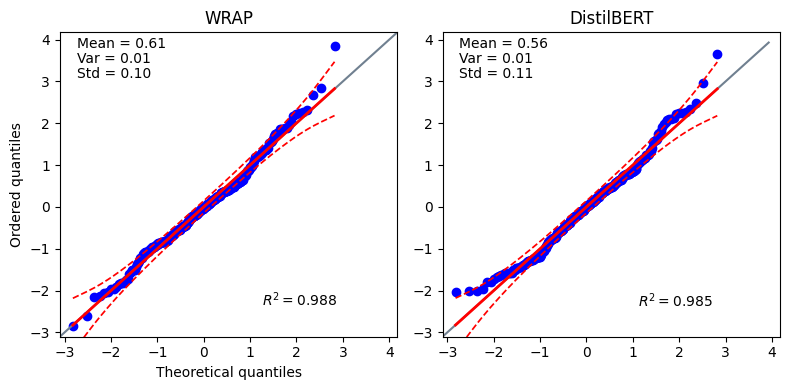


>Test: Two-Way Repeated Measures ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,seed,0.01,2,576,0.00,0.97,0.38,0.38,0.00,1.00
1,model,1.25,3,864,0.42,69.47,0.00,0.00,0.03,0.56
2,seed * model,0.04,6,1728,0.01,4.82,0.00,0.01,0.00,0.38



>Pairwise comparisons after ANOVA (two-sided)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,model,TomatenMarc/WRAPresentations,bert-base-uncased,True,True,8.12,288.0,two-sided,0.00,0.00,bonf,4.049e+11,0.39
1,model,TomatenMarc/WRAPresentations,distilbert-base-uncased,True,True,10.14,288.0,two-sided,0.00,0.00,bonf,5.411e+17,0.49
2,model,TomatenMarc/WRAPresentations,roberta-base,True,True,9.09,288.0,two-sided,0.00,0.00,bonf,2.864e+14,0.40
3,model,bert-base-uncased,distilbert-base-uncased,True,True,5.20,288.0,two-sided,0.00,0.00,bonf,2.348e+04,0.09
4,model,bert-base-uncased,roberta-base,True,True,1.14,288.0,two-sided,0.25,1.00,bonf,0.126,0.02
5,model,distilbert-base-uncased,roberta-base,True,True,-2.73,288.0,two-sided,0.01,0.04,bonf,2.54,-0.06



>Pairwise comparisons after ANOVA (one-sided)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,model,TomatenMarc/WRAPresentations,bert-base-uncased,True,True,8.12,288.0,greater,0.00,0.00,bonf,8.097e+11,0.39
1,model,TomatenMarc/WRAPresentations,distilbert-base-uncased,True,True,10.14,288.0,greater,0.00,0.00,bonf,1.082e+18,0.49
2,model,TomatenMarc/WRAPresentations,roberta-base,True,True,9.09,288.0,greater,0.00,0.00,bonf,5.728e+14,0.40
3,model,bert-base-uncased,distilbert-base-uncased,True,True,5.20,288.0,greater,0.00,0.00,bonf,4.696e+04,0.09
4,model,bert-base-uncased,roberta-base,True,True,1.14,288.0,greater,0.13,0.76,bonf,0.251,0.02
5,model,distilbert-base-uncased,roberta-base,True,True,-2.73,288.0,greater,1.00,1.00,bonf,0.197,-0.06


In [9]:
models = [WRAP, BERT, ROBERTA, DISTILBERT]

df_train_long = long_data(models, train_results_42, train_results_51099, train_results_374318)

display(df_train_long.info())
display(df_train_long.head())

print(f">Test: Normality (D'Agostino and Spearman)")
train_normal_results = df_train_long.groupby(["seed", "model"])["macro_f1"].apply(lambda x: pg.normality(x, method="normaltest", alpha=0.05))
display(train_normal_results.round(2))

plot_qq([df_train_long[(df_train_long["seed"] == "374318") & (df_train_long["model"] == WRAP)],
        df_train_long[(df_train_long["seed"] == "374318") & (df_train_long["model"] == DISTILBERT)]])

print("\n>Test: Two-Way Repeated Measures ANOVA")
train_rm_anova_results = pg.rm_anova(
    data=df_train_long, dv="macro_f1", within=["seed", "model"], subject="pair", detailed= True, correction=True
)
display(train_rm_anova_results.round(2))

print("\n>Pairwise comparisons after ANOVA (two-sided)")
train_rm_paired_results = pg.pairwise_ttests(
    data=df_train_long, dv="macro_f1", within=["model"], subject="pair", padjust="bonf", effsize="cohen", alternative="two-sided", correction=True
)
display(train_rm_paired_results.round(2))

print("\n>Pairwise comparisons after ANOVA (one-sided)")
train_rm_paired_greater_results = pg.pairwise_ttests(
    data=df_train_long, dv="macro_f1", within=["model"], subject="pair", padjust="bonf", effsize="cohen", alternative="greater", correction=True
)
display(train_rm_paired_greater_results.round(2))

## To what transformers pay attention

In [10]:
time = sum([result["time_sec"] for result in pay_results_42 + pay_results_51099 + pay_results_374318])
print(f"Run-Time (3 Samples): {seconds_to_time(time)}")

Run-Time (3 Samples): 38h:33m:17s


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3468 entries, 0 to 3467
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pair      3468 non-null   object  
 1   seed      3468 non-null   category
 2   model     3468 non-null   category
 3   macro_f1  3468 non-null   float64 
dtypes: category(2), float64(1), object(1)
memory usage: 61.4+ KB


None

,pair,seed,model,macro_f1
0,"(ABSTRCT, ABSTRCT)",42,TomatenMarc/WRAPresentations,0.826132
1,"(ACQUA, ABSTRCT)",42,TomatenMarc/WRAPresentations,0.357685
2,"(AEC, ABSTRCT)",42,TomatenMarc/WRAPresentations,0.531034
3,"(AFS, ABSTRCT)",42,TomatenMarc/WRAPresentations,0.542973
4,"(ARGUMINSCI, ABSTRCT)",42,TomatenMarc/WRAPresentations,0.628054


>Test: Normality (D'Agostino and Spearman)


W  \
seed   model                                                                     
374318 TomatenMarc/WRAPresentations 374318 TomatenMarc/WRAPresentations  10.70   
       bert-base-uncased            374318 bert-base-uncased              2.30   
       distilbert-base-uncased      374318 distilbert-base-uncased        0.86   
       roberta-base                 374318 roberta-base                   0.46   
42     TomatenMarc/WRAPresentations 42     TomatenMarc/WRAPresentations   1.52   
       bert-base-uncased            42     bert-base-uncased              3.20   
       distilbert-base-uncased      42     distilbert-base-uncased        0.89   
       roberta-base                 42     roberta-base                   3.40   
51099  TomatenMarc/WRAPresentations 51099  TomatenMarc/WRAPresentations   4.05   
       bert-base-uncased            51099  bert-base-uncased              0.49   
       distilbert-base-uncased      51099  distilbert-base-uncased        1.76   
       roberta-base                 51099  roberta-base                   5.65   

                                                                         pval  \
seed   model                                                                    
374318 TomatenMarc/WRAPresentations 374318 TomatenMarc/WRAPresentations  0.00   
       bert-base-uncased            374318 bert-base-uncased             0.32   
       distilbert-base-uncased      374318 distilbert-base-uncased       0.65   
       roberta-base                 374318 roberta-base                  0.80   
42     TomatenMarc/WRAPresentations 42     TomatenMarc/WRAPresentations  0.47   
       bert-base-uncased            42     bert-base-uncased             0.20   
       distilbert-base-uncased      42     distilbert-base-uncased       0.64   
       roberta-base                 42     roberta-base                  0.18   
51099  TomatenMarc/WRAPresentations 51099  TomatenMarc/WRAPresentations  0.13   
       bert-base-uncased            51099  bert-base-uncased             0.78   
       distilbert-base-uncased      51099  distilbert-base-uncased       0.42   
       roberta-base                 51099  roberta-base                  0.06   

                                                                         normal  
seed   model                                                                     
374318 TomatenMarc/WRAPresentations 374318 TomatenMarc/WRAPresentations   False  
       bert-base-uncased            374318 bert-base-uncased               True  
       distilbert-base-uncased      374318 distilbert-base-uncased         True  
       roberta-base                 374318 roberta-base                    True  
42     TomatenMarc/WRAPresentations 42     TomatenMarc/WRAPresentations    True  
       bert-base-uncased            42     bert-base-uncased               True  
       distilbert-base-uncased      42     distilbert-base-uncased         True  
       roberta-base                 42     roberta-base                    True  
51099  TomatenMarc/WRAPresentations 51099  TomatenMarc/WRAPresentations    True  
       bert-base-uncased            51099  bert-base-uncased               True  
       distilbert-base-uncased      51099  distilbert-base-uncased         True  
       roberta-base                 51099  roberta-base                    True

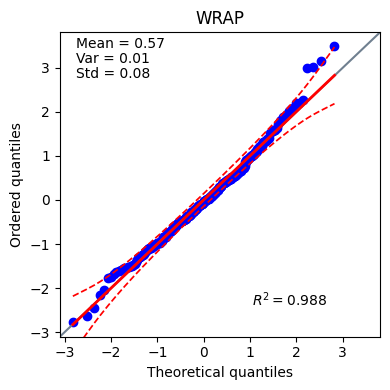


>Test: Two-Way Repeated Measures ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,seed,0.04,2,576,0.02,6.11,0.0,0.0,0.00,0.99
1,model,0.21,3,864,0.07,22.88,0.0,0.0,0.01,0.72
2,seed * model,0.03,6,1728,0.01,4.41,0.0,0.0,0.00,0.62


In [11]:
models = [WRAP, BERT, ROBERTA, DISTILBERT]

df_pay_long = long_data(models, pay_results_42, pay_results_51099, pay_results_374318)

display(df_pay_long.info())
display(df_pay_long.head())

print(f">Test: Normality (D'Agostino and Spearman)")
pay_normal_results = df_pay_long.groupby(["seed", "model"])["macro_f1"].apply(lambda x: pg.normality(x, method="normaltest", alpha=0.05))
display(pay_normal_results.round(2))
plot_qq([df_pay_long[(df_pay_long["seed"] == "374318") & (df_pay_long["model"] == WRAP)]])

print("\n>Test: Two-Way Repeated Measures ANOVA")
pay_rm_anova_results = pg.rm_anova(
    data=df_pay_long, dv="macro_f1", within=["seed", "model"], subject="pair", detailed= True, correction=True
)
display(pay_rm_anova_results.round(2))

## Leave one out

In [12]:
time = sum([result["time_sec"] for result in leave_results_42 + leave_results_51099 + leave_results_374318])
print(f"Run-Time (3 Samples): {seconds_to_time(time)}")

Run-Time (3 Samples): 22h:47m:16s


In [13]:
models = [WRAP, BERT, ROBERTA, DISTILBERT]

df_leave_long = long_data(models, leave_results_42, leave_results_51099, leave_results_374318)

display(df_leave_long.info())
display(df_leave_long.head())

print(f">Test: Normality (D'Agostino and Spearman)")
leave_normal_results = df_leave_long.groupby(["seed", "model"])["macro_f1"].apply(lambda x: pg.normality(x, method="normaltest", alpha=0.05))
display(leave_normal_results.round(2))

print("\n>Test: Two-Way Repeated Measures ANOVA")
leave_rm_anova_results = pg.rm_anova(
    data=df_leave_long, dv="macro_f1", within=["seed", "model"], subject="pair", detailed= True, correction=True
)
display(leave_rm_anova_results.round(2))

print("\n>Pairwise comparisons after ANOVA (two-sided)")
leave_rm_paired_results = pg.pairwise_ttests(
    data=df_leave_long, dv="macro_f1", within=["model"], subject="pair", padjust="bonf", effsize="cohen", alternative="two-sided", correction=True
)
display(leave_rm_paired_results.round(2))

print("\n>Pairwise comparisons after ANOVA (one-sided)")
leave_rm_paired_greater_results = pg.pairwise_ttests(
    data=df_leave_long, dv="macro_f1", within=["model"], subject="pair", padjust="bonf", effsize="cohen", alternative="greater", correction=True
)
display(leave_rm_paired_greater_results.round(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3468 entries, 0 to 3467
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pair      3468 non-null   object  
 1   seed      3468 non-null   category
 2   model     3468 non-null   category
 3   macro_f1  204 non-null    float64 
dtypes: category(2), float64(1), object(1)
memory usage: 61.4+ KB


None

,pair,seed,model,macro_f1
0,"(ABSTRCT, ABSTRCT)",42,TomatenMarc/WRAPresentations,0.737242
1,"(ACQUA, ABSTRCT)",42,TomatenMarc/WRAPresentations,NaN
2,"(AEC, ABSTRCT)",42,TomatenMarc/WRAPresentations,NaN
3,"(AFS, ABSTRCT)",42,TomatenMarc/WRAPresentations,NaN
4,"(ARGUMINSCI, ABSTRCT)",42,TomatenMarc/WRAPresentations,NaN


>Test: Normality (D'Agostino and Spearman)


W  \
seed   model                                                                    
374318 TomatenMarc/WRAPresentations 374318 TomatenMarc/WRAPresentations  0.29   
       bert-base-uncased            374318 bert-base-uncased             2.78   
       distilbert-base-uncased      374318 distilbert-base-uncased       0.73   
       roberta-base                 374318 roberta-base                  1.90   
42     TomatenMarc/WRAPresentations 42     TomatenMarc/WRAPresentations  1.06   
       bert-base-uncased            42     bert-base-uncased             1.24   
       distilbert-base-uncased      42     distilbert-base-uncased       2.47   
       roberta-base                 42     roberta-base                  1.28   
51099  TomatenMarc/WRAPresentations 51099  TomatenMarc/WRAPresentations  0.31   
       bert-base-uncased            51099  bert-base-uncased             3.65   
       distilbert-base-uncased      51099  distilbert-base-uncased       1.88   
       roberta-base                 51099  roberta-base                  0.04   

                                                                         pval  \
seed   model                                                                    
374318 TomatenMarc/WRAPresentations 374318 TomatenMarc/WRAPresentations  0.86   
       bert-base-uncased            374318 bert-base-uncased             0.25   
       distilbert-base-uncased      374318 distilbert-base-uncased       0.70   
       roberta-base                 374318 roberta-base                  0.39   
42     TomatenMarc/WRAPresentations 42     TomatenMarc/WRAPresentations  0.59   
       bert-base-uncased            42     bert-base-uncased             0.54   
       distilbert-base-uncased      42     distilbert-base-uncased       0.29   
       roberta-base                 42     roberta-base                  0.53   
51099  TomatenMarc/WRAPresentations 51099  TomatenMarc/WRAPresentations  0.86   
       bert-base-uncased            51099  bert-base-uncased             0.16   
       distilbert-base-uncased      51099  distilbert-base-uncased       0.39   
       roberta-base                 51099  roberta-base                  0.98   

                                                                         normal  
seed   model                                                                     
374318 TomatenMarc/WRAPresentations 374318 TomatenMarc/WRAPresentations    True  
       bert-base-uncased            374318 bert-base-uncased               True  
       distilbert-base-uncased      374318 distilbert-base-uncased         True  
       roberta-base                 374318 roberta-base                    True  
42     TomatenMarc/WRAPresentations 42     TomatenMarc/WRAPresentations    True  
       bert-base-uncased            42     bert-base-uncased               True  
       distilbert-base-uncased      42     distilbert-base-uncased         True  
       roberta-base                 42     roberta-base                    True  
51099  TomatenMarc/WRAPresentations 51099  TomatenMarc/WRAPresentations    True  
       bert-base-uncased            51099  bert-base-uncased               True  
       distilbert-base-uncased      51099  distilbert-base-uncased         True  
       roberta-base                 51099  roberta-base                    True


>Test: Two-Way Repeated Measures ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,seed,0.00,2,32,0.00,0.14,0.87,0.83,0.00,0.84
1,model,0.02,3,48,0.01,5.25,0.00,0.02,0.02,0.52
2,seed * model,0.01,6,96,0.00,2.44,0.03,0.10,0.00,0.37



>Pairwise comparisons after ANOVA (two-sided)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,model,TomatenMarc/WRAPresentations,bert-base-uncased,True,True,2.42,16.0,two-sided,0.03,0.17,bonf,2.356,0.32
1,model,TomatenMarc/WRAPresentations,distilbert-base-uncased,True,True,2.51,16.0,two-sided,0.02,0.14,bonf,2.722,0.37
2,model,TomatenMarc/WRAPresentations,roberta-base,True,True,1.44,16.0,two-sided,0.17,1.00,bonf,0.6,0.14
3,model,bert-base-uncased,distilbert-base-uncased,True,True,1.28,16.0,two-sided,0.22,1.00,bonf,0.5,0.07
4,model,bert-base-uncased,roberta-base,True,True,-2.04,16.0,two-sided,0.06,0.35,bonf,1.316,-0.17
5,model,distilbert-base-uncased,roberta-base,True,True,-2.68,16.0,two-sided,0.02,0.10,bonf,3.593,-0.23



>Pairwise comparisons after ANOVA (one-sided)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,model,TomatenMarc/WRAPresentations,bert-base-uncased,True,True,2.42,16.0,greater,0.01,0.08,bonf,4.713,0.32
1,model,TomatenMarc/WRAPresentations,distilbert-base-uncased,True,True,2.51,16.0,greater,0.01,0.07,bonf,5.445,0.37
2,model,TomatenMarc/WRAPresentations,roberta-base,True,True,1.44,16.0,greater,0.08,0.50,bonf,1.199,0.14
3,model,bert-base-uncased,distilbert-base-uncased,True,True,1.28,16.0,greater,0.11,0.66,bonf,1.0,0.07
4,model,bert-base-uncased,roberta-base,True,True,-2.04,16.0,greater,0.97,1.00,bonf,0.38,-0.17
5,model,distilbert-base-uncased,roberta-base,True,True,-2.68,16.0,greater,0.99,1.00,bonf,0.139,-0.23


# Train on one, test on another

In [14]:
train_wrap_42 = create_model_matrix(train_results_42, WRAP)
train_bert_42 = create_model_matrix(train_results_42, BERT)
train_roberta_42 = create_model_matrix(train_results_42, ROBERTA)
train_distilbert_42 = create_model_matrix(train_results_42, DISTILBERT)
train_dtree_42 = create_model_matrix(train_results_42, DTREE)
train_random_42 = create_model_matrix(train_results_42, RANDOM)

In [15]:
model_ranking_by_mean(
    train_wrap_42.values,
    train_bert_42.values,
    train_roberta_42.values,
    train_distilbert_42.values,
    train_dtree_42.values,
    train_random_42.values)

WRAP, mean macro F1: 0.61, std: 0.10, var: 0.01
BERT, mean macro F1: 0.58, std: 0.11, var: 0.01
DTree, mean macro F1: 0.57, std: 0.06, var: 0.00
RoBERTa, mean macro F1: 0.57, std: 0.12, var: 0.01
DistilBERT, mean macro F1: 0.56, std: 0.11, var: 0.01
Random, mean macro F1: 0.52, std: 0.00, var: 0.00


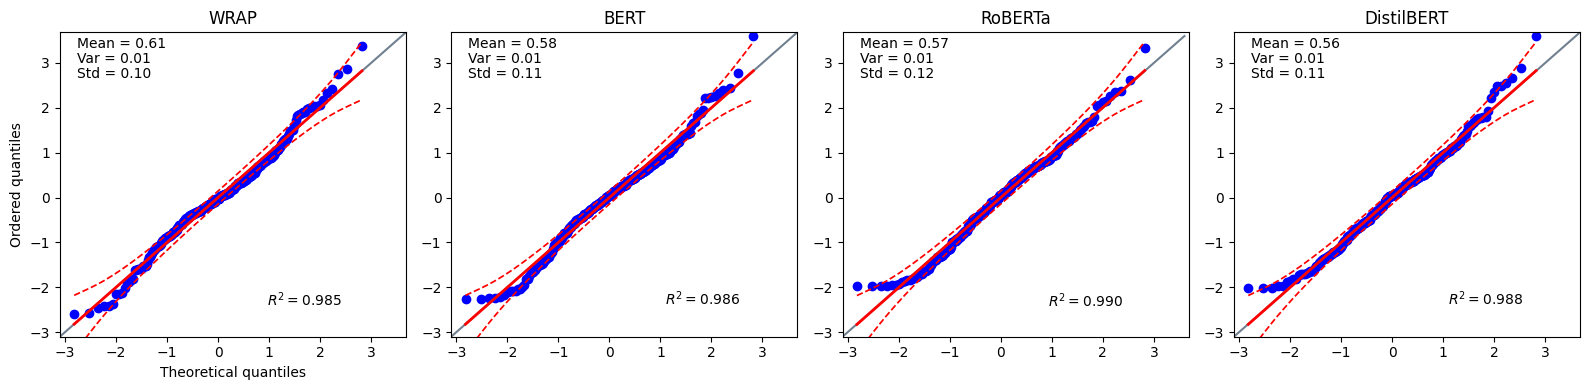

In [16]:
plot_qq([df_train_long[(df_train_long["seed"] == "42") & (df_train_long["model"] == WRAP)],
        df_train_long[(df_train_long["seed"] == "42") & (df_train_long["model"] == BERT)],
        df_train_long[(df_train_long["seed"] == "42") & (df_train_long["model"] == ROBERTA)],
        df_train_long[(df_train_long["seed"] == "42") & (df_train_long["model"] == DISTILBERT)]],
        f"./output/images/qq-42.pdf")

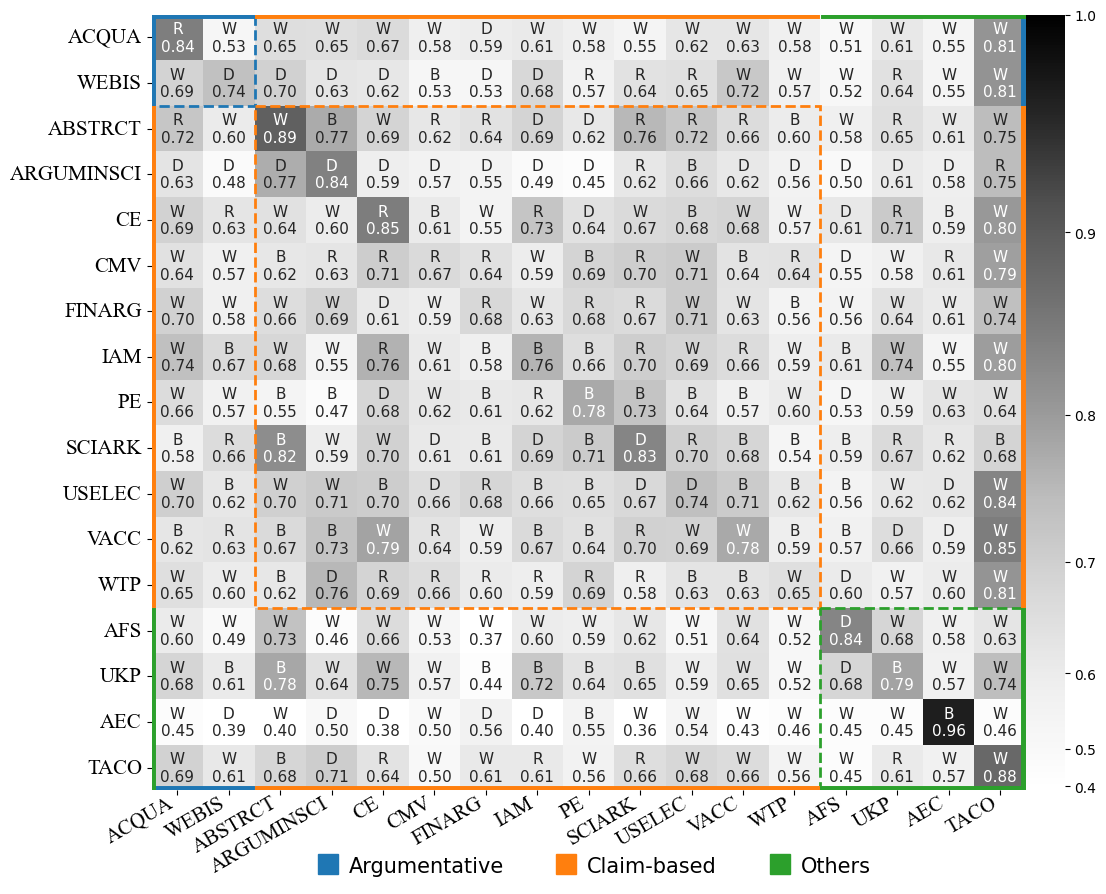

In [17]:
best_matrix, best_annotations = create_best_matrix(
    [train_wrap_42, train_bert_42, train_roberta_42, train_distilbert_42]
)

df_datasets_by_definitions = pd.read_csv("./datasets.csv")[["Dataset", "Definition"]]
filtered_data = df_datasets_by_definitions[df_datasets_by_definitions["Dataset"].isin(best_matrix.columns)]
order_datasets = filtered_data["Dataset"].tolist()

best_matrix = best_matrix.reindex(index=order_datasets, columns=order_datasets)
best_annotations = best_annotations.reindex(index=order_datasets, columns=order_datasets)
best_matrix.name = "SOTA"
plt.figure(figsize=(12, 9))
cmap = "Greys"
norm = mcolors.PowerNorm(gamma=1.95, vmin=best_matrix.min().min(), vmax=1)  # Adjust gamma as needed
sns.heatmap(
    best_matrix.astype(float),
    annot=best_annotations,
    cmap=cmap,
    cbar=True,
    cbar_kws={"pad": 0},
    fmt="",
    norm=norm,
    vmax=1,
    annot_kws={"size": 11}
)
#rects
# Draw rectangles on the heatmap
plt.gca().add_patch(patches.Rectangle((0, 0), 2, 2, linewidth=2, linestyle='dashed', edgecolor='tab:blue', facecolor='none', label='Argumentative'))
plt.gca().add_patch(patches.Rectangle((2, 2), 11, 11, linewidth=2, linestyle='dashed', edgecolor='tab:orange', facecolor='none', label='Claim-based'))
plt.gca().add_patch(patches.Rectangle((13, 13), 17, 17, linewidth=2, linestyle='dashed', edgecolor='tab:green', facecolor='none', label='Others'))

# lines
plt.plot([0, 0], [0, 1.925], color='tab:blue', linewidth=5)
plt.plot([0, 1.925], [0, 0], color='tab:blue', linewidth=5)
plt.plot([16.975, 16.975], [0, 1.925], color='tab:blue', linewidth=5)
plt.plot([0, 1.925], [16.975, 16.975], color='tab:blue', linewidth=5)

plt.plot([0, 0], [2.075, 12.925], color='tab:orange', linewidth=5)
plt.plot([2.075, 12.925], [0, 0], color='tab:orange', linewidth=5)
plt.plot([16.975, 16.975], [2.075, 12.925], color='tab:orange', linewidth=5)
plt.plot([2.075, 12.925], [16.975, 16.975], color='tab:orange', linewidth=5)

plt.plot([0, 0], [13.075, 16.975], color='tab:green', linewidth=5)
plt.plot([13.075, 16.975], [0, 0], color='tab:green', linewidth=5)
plt.plot([16.975, 16.975], [13.075, 16.975], color='tab:green', linewidth=5)
plt.plot([13.075, 16.975], [16.975, 16.975], color='tab:green', linewidth=5)

# Create custom dot markers for the legend
argumentative_marker = mlines.Line2D([], [], color='tab:blue', marker='s', linestyle='None', markersize=10, label='Argumentative')
claim_premise_marker = mlines.Line2D([], [], color='tab:orange', marker='s', linestyle='None', markersize=10, label='Claim-based')
custom_marker = mlines.Line2D([], [], color='tab:green', marker='s', linestyle='None', markersize=10, label='Others')

# Add the custom legend
plt.legend(
    handles=[argumentative_marker, claim_premise_marker, custom_marker],
    loc='upper center',
    bbox_to_anchor=(0.5, -.06),
    ncol=3,
    fontsize=15,          # Increase text size
    markerscale=1.5,
    frameon=False,
    handletextpad=0
)

xticks_locs, xticks_labels = plt.xticks()
plt.xticks(xticks_locs, xticks_labels, rotation=30, ha="right", va="center_baseline", fontproperties=times_new_roman_font)

yticks_locs, yticks_labels = plt.yticks()
plt.yticks(yticks_locs, yticks_labels, fontproperties=times_new_roman_font)

plt.tight_layout()
plt.savefig(f"./output/images/train-on-one-test-another-42.pdf", format="pdf", bbox_inches='tight')

plt.show()

In [18]:
model_counts_df = best_annotations.applymap(lambda x: x.split("\n")[0] if isinstance(x, str) else x).stack().value_counts().reset_index()
model_counts_df.columns = ['Model', 'Count']

model_counts_df['Percentage'] = (model_counts_df['Count'] / model_counts_df['Count'].sum()) * 100
model_counts_df["Model"] = model_counts_df["Model"].replace({"W": "WRAP", "B": "BERT", "R": "RoBERTa", "D": "DistilBERT"})
model_counts_df.round()

,Model,Count,Percentage
0,WRAP,133,46.0
1,BERT,58,20.0
2,RoBERTa,50,17.0
3,DistilBERT,48,17.0


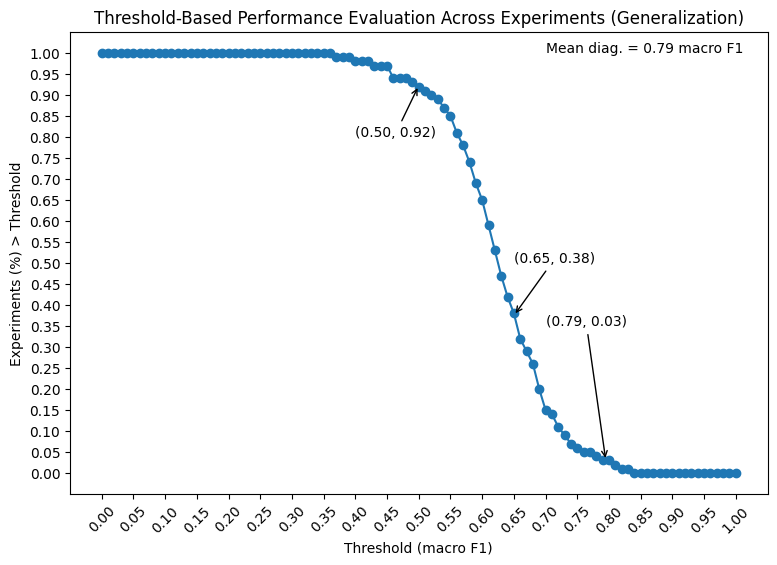

In [19]:
df_best_matrix_long = melt_down(best_matrix)
df_best_matrix_long_generalization = df_best_matrix_long[df_best_matrix_long["pair"].apply(lambda x: x[0] != x[1])]

thresholds = np.arange(0, 1.01, 0.01)
exceed_counts = [
    ((df_best_matrix_long_generalization["value"] >= t).sum()/df_best_matrix_long_generalization.shape[0]).round(2)
    for t in thresholds
]

# Create the plot
plt.figure(figsize=(9, 6))
plt.plot(thresholds, exceed_counts, marker='o', linestyle='-')
plt.xticks(np.arange(0, 1.01, 0.05), rotation=45)
plt.yticks(np.arange(0, 1.01, 0.05))

# Labels and title
plt.xlabel("Threshold (macro F1)")
plt.ylabel("Experiments (%) > Threshold")

mean_macro_f1_diag = get_diagonal(best_matrix).mean(axis=1).values[0]
experiments_above_mean_diag = (df_best_matrix_long_generalization["value"] >= mean_macro_f1_diag).sum()/df_best_matrix_long_generalization.shape[0]
experiments_below_65 = (df_best_matrix_long_generalization["value"] >= 0.65).sum()/df_best_matrix_long_generalization.shape[0]
experiments_below_50 = (df_best_matrix_long_generalization["value"] >= 0.5).sum()/df_best_matrix_long_generalization.shape[0]


plt.annotate(f"({mean_macro_f1_diag:.2f}, {experiments_above_mean_diag:.2f})", xy=(mean_macro_f1_diag, experiments_above_mean_diag), xytext=(0.7, 0.35),
             arrowprops=dict(arrowstyle="->", color="black"), color="black")
plt.annotate(f"({0.65:.2f}, {experiments_below_65:.2f})", xy=(0.65, experiments_below_65), xytext=(0.65, 0.50),
             arrowprops=dict(arrowstyle="->", color="black"), color="black")
plt.annotate(f"({0.5:.2f}, {experiments_below_50:.2f})", xy=(0.5, experiments_below_50), xytext=(0.4, 0.80),
             arrowprops=dict(arrowstyle="->", color="black"), color="black")

plt.text(0.7, 1, f"Mean diag. = {mean_macro_f1_diag:.2f} macro F1")
plt.grid(False)
plt.title("Threshold-Based Performance Evaluation Across Experiments (Generalization)")
# Show the plot
plt.show()

In [20]:
df_predictions = pd.DataFrame()

for model in [WRAP, BERT, ROBERTA, DISTILBERT]:
    for result in select_model(train_results_42, model):
        df_test = result["df_test"]
        df_test["model"] = model
        df_predictions = pd.concat([df_predictions, df_test])

df_predictions = df_predictions.merge(df_42[["dataset_id", "label"]], on="dataset_id")

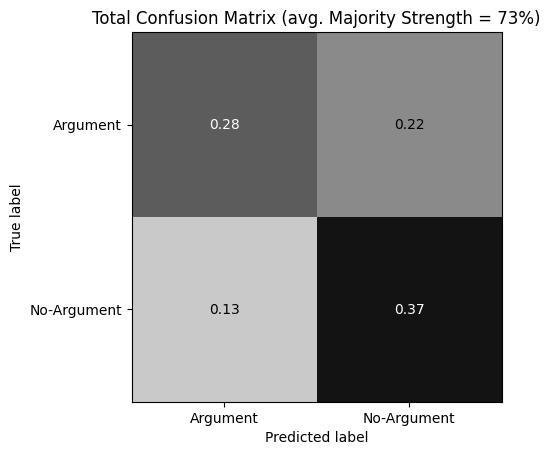

In [21]:
df_aggregated_overall = df_predictions.groupby(["dataset_id"]).agg(
    label=("label", "first"), # Assume the label is consistent
    prediction=("prediction", lambda x: x.mode()[0]), # Take the most frequent prediction
    majority_size=("prediction", lambda x: x.value_counts().max()),
    total_count=("prediction", "count")
).reset_index()

cm = confusion_matrix(df_aggregated_overall["label"], df_aggregated_overall["prediction"], labels=["Argument", "No-Argument"], normalize='all')

# Display confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Argument", "No-Argument"])
disp.plot(cmap="Greys", im_kw={"vmin": 0, "vmax": 0.4}, colorbar=False)
plt.title(f"Total Confusion Matrix (avg. Majority Strength = {100*(df_aggregated_overall['majority_size'].mean()/df_aggregated_overall['total_count'].unique()[0]):.0f}%)")
plt.show()

Avg. Majority Strength = 75%
WRAP: Avg. Majority Strength = 78%
BERT: Avg. Majority Strength = 74%
RoBERTa: Avg. Majority Strength = 74%
DistilBERT: Avg. Majority Strength = 75%


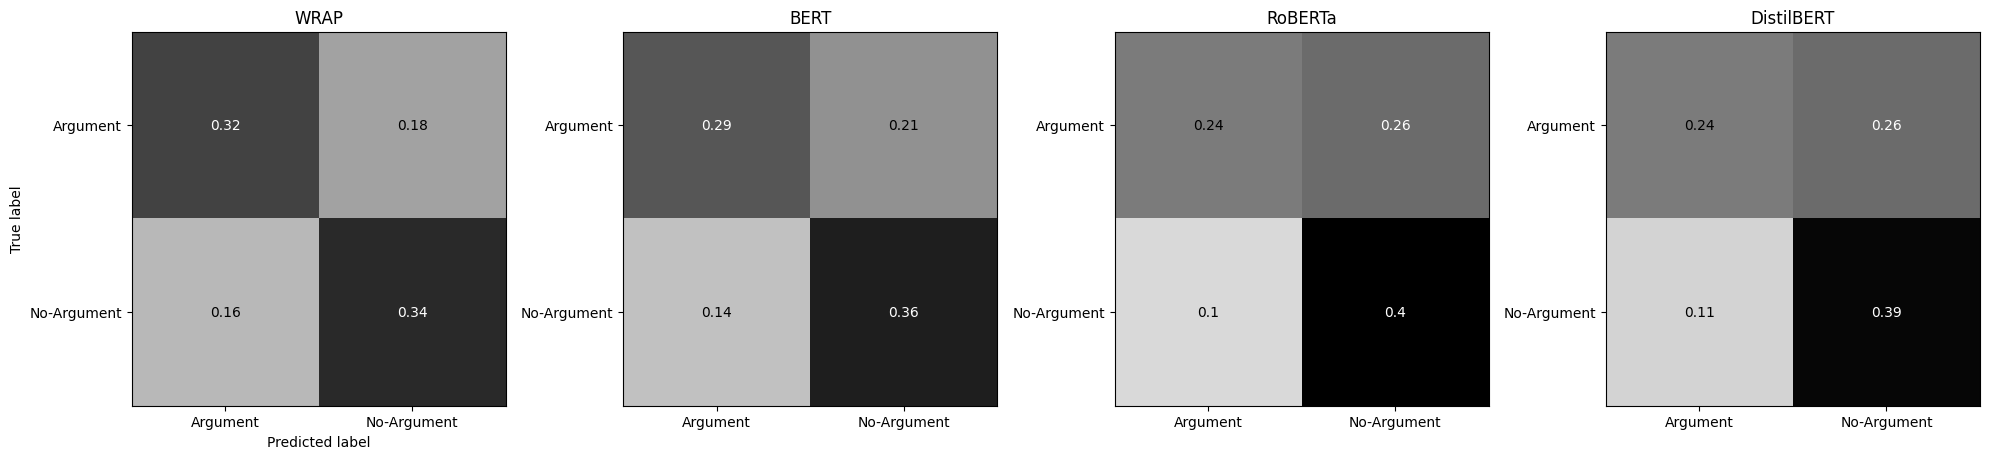

In [22]:
df_aggregated_per_model = df_predictions.groupby(["model", "dataset_id"]).agg(
    label=("label", "first"), # Assume the label is consistent
    prediction=("prediction", lambda x: x.mode()[0]), # Take the most frequent prediction
    majority_size=("prediction", lambda x: x.value_counts().max()),
    total_count=("prediction", "count")
).reset_index()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
majority_strength = 100 * (df_aggregated_per_model["majority_size"].mean() / df_aggregated_per_model["total_count"].mean())
print(f"Avg. Majority Strength = {majority_strength:.0f}%")
for index, model in enumerate([WRAP, BERT, ROBERTA, DISTILBERT]):
    cm = confusion_matrix(df_aggregated_per_model[df_aggregated_per_model["model"] == model]["label"],
                          df_aggregated_per_model[df_aggregated_per_model["model"] == model]["prediction"],
                          labels=["Argument", "No-Argument"],
                          normalize="all")
    # Display confusion matrix as a heatmap
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Argument", "No-Argument"])
    disp.plot(cmap="Greys", ax=axes[index], im_kw={"vmin": 0, "vmax": 0.4}, colorbar=False)
    model_majority_strength = 100 * (df_aggregated_per_model[df_aggregated_per_model["model"] == model]["majority_size"].mean() / df_aggregated_per_model[df_aggregated_per_model["model"] == model]["total_count"].mean())
    model = model_name_map.get(model)
    print(f"{model}: Avg. Majority Strength = {model_majority_strength:.0f}%")
    axes[index].set_title(f"{model}")

for i, ax in enumerate(axes):
    if i != 0:
        ax.set_xlabel('')
        ax.set_ylabel('')

plt.tight_layout()
plt.savefig(f"./output/images/model-confusion-42.pdf", format="pdf", bbox_inches='tight')

plt.show()

# To what transformers pay attention

In [23]:
pay_wrap_42 = create_model_matrix(pay_results_42, WRAP)
pay_bert_42 = create_model_matrix(pay_results_42, BERT)
pay_roberta_42 = create_model_matrix(pay_results_42, ROBERTA)
pay_distilbert_42 = create_model_matrix(pay_results_42, DISTILBERT)

In [24]:
model_ranking_by_mean(
    pay_wrap_42.values,
    pay_bert_42.values,
    pay_roberta_42.values,
    pay_distilbert_42.values,
    [0],
    [0])

RoBERTa, mean macro F1: 0.57, std: 0.10, var: 0.01
WRAP, mean macro F1: 0.56, std: 0.09, var: 0.01
BERT, mean macro F1: 0.56, std: 0.09, var: 0.01
DistilBERT, mean macro F1: 0.55, std: 0.10, var: 0.01
DTree, mean macro F1: 0.00, std: 0.00, var: 0.00
Random, mean macro F1: 0.00, std: 0.00, var: 0.00


In [25]:
df_sota_42 = df_train_long[df_train_long["seed"] == "42"]
df_sota_42.loc[:, "stage"] = "State-of-the-art"
df_ablation_42 = df_pay_long[df_pay_long["seed"] == "42"]
df_ablation_42.loc[:, "stage"] = "Ablation"

df_showdown = pd.concat([df_sota_42, df_ablation_42])
pairwise_results = df_showdown.groupby("model").apply(
    lambda x: pg.pairwise_tests(
        data=x,
        dv="macro_f1",
        within="stage",
        subject="pair",
        alternative="less",
        padjust="bonf",
        effsize="cohen",
        correction=True
    ).assign(Model=x["model"].iloc[0])
).reset_index(drop=True)
pairwise_results = pairwise_results.drop(columns=["Contrast"])
pairwise_results = pairwise_results[["Model"] + [col for col in pairwise_results.columns if col != "Model"]]
pairwise_results.round(2)

,Model,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,TomatenMarc/WRAPresentations,Ablation,State-of-the-art,True,True,-8.91,288.0,less,0.00,1.677e+14,-0.49
1,bert-base-uncased,Ablation,State-of-the-art,True,True,-3.88,288.0,less,0.00,191.754,-0.17
2,distilbert-base-uncased,Ablation,State-of-the-art,True,True,-2.35,288.0,less,0.01,1.959,-0.09
3,roberta-base,Ablation,State-of-the-art,True,True,0.14,288.0,less,0.56,0.133,0.01


In [26]:
correlation_results = []
for model in df_showdown["model"].unique():
    a = df_showdown[(df_showdown["model"] == model) & (df_showdown["stage"] == "State-of-the-art")]
    b = df_showdown[(df_showdown["model"] == model) & (df_showdown["stage"] == "Ablation")]
    c = pd.DataFrame({
        "State-of-the-art": a["macro_f1"].values,
        "Ablation": b["macro_f1"].values
    })
    corr_df = pg.pairwise_corr(c, method="pearson", padjust="bonf")
    corr_df["Model"] = model
    correlation_results.append(corr_df)

pairwise_corr_results = pd.concat(correlation_results).reset_index(drop=True)
pairwise_corr_results = pairwise_corr_results[["Model"] + [col for col in pairwise_corr_results.columns if col != "Model"]]
pairwise_corr_results.round(2)

,Model,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,TomatenMarc/WRAPresentations,State-of-the-art,Ablation,pearson,two-sided,289,0.57,"[0.49, 0.65]",0.0,4.307e+23,1.0
1,bert-base-uncased,State-of-the-art,Ablation,pearson,two-sided,289,0.72,"[0.66, 0.77]",0.0,4.607e+43,1.0
2,roberta-base,State-of-the-art,Ablation,pearson,two-sided,289,0.77,"[0.71, 0.81]",0.0,4.74e+53,1.0
3,distilbert-base-uncased,State-of-the-art,Ablation,pearson,two-sided,289,0.79,"[0.74, 0.83]",0.0,2.217e+58,1.0


In [27]:
content_matrix = pd.concat([
    get_diagonal(pay_wrap_42),
    get_diagonal(pay_bert_42),
    get_diagonal(pay_roberta_42),
    get_diagonal(pay_distilbert_42),
    get_diagonal(best_matrix)
], axis=0).round(2)

difference_max = (content_matrix.loc["SOTA"]-content_matrix.drop("SOTA")).min().to_frame().T
difference_max.index = ["delta_max"]

difference_min = (content_matrix.loc["SOTA"]-content_matrix.drop("SOTA")).max().to_frame().T
difference_min.index = ["delta_min"]

span_min_max = difference_min.reset_index(drop=True) - difference_max.reset_index(drop=True)
span_min_max.index = ["span"]

content_matrix = pd.concat([content_matrix, difference_max, difference_min, span_min_max])
content_matrix = content_matrix.reindex(columns=order_datasets)
content_matrix.T

,TomatenMarc/WRAPresentations,bert-base-uncased,roberta-base,distilbert-base-uncased,SOTA,delta_max,delta_min,span
ACQUA,0.73,0.77,0.76,0.78,0.84,0.06,0.11,0.05
WEBIS,0.61,0.66,0.66,0.67,0.74,0.07,0.13,0.06
ABSTRCT,0.83,0.87,0.84,0.87,0.89,0.02,0.06,0.04
ARGUMINSCI,0.78,0.79,0.77,0.77,0.84,0.05,0.07,0.02
CE,0.75,0.79,0.77,0.81,0.85,0.04,0.10,0.06
CMV,0.57,0.64,0.64,0.65,0.67,0.02,0.10,0.08
FINARG,0.62,0.61,0.66,0.69,0.68,-0.01,0.07,0.08
IAM,0.66,0.69,0.71,0.70,0.76,0.05,0.10,0.05
PE,0.66,0.67,0.71,0.73,0.78,0.05,0.12,0.07
SCIARK,0.71,0.80,0.77,0.79,0.83,0.03,0.12,0.09


In [28]:
def bold_max(s):
    max_value = s[:4].max()
    return [f"\\textbf{{{v}}}" if v == max_value else str(v) for v in s]

def italicize_min(s):
    min_value = s[:4].min()
    return [f"\\textit{{{v}}}" if v == min_value else str(v) for v in s]

def bold_sota(s):
    return [f"\\textbf{{{v}}}" for v in s]

def underline_delta(s):
    return [f"\\underline{{{v}}}" if not (0 < float(v) and float(v) < 0.3) else str(v) for v in s]

def underline_sota(s):
    return [f"\\underline{{{v}}}" if (v == "\\textbf{0.96}") else str(v) for v in s]

latex_content_matrix = content_matrix.round(2).apply(bold_max, axis=0)
latex_content_matrix = latex_content_matrix.apply(italicize_min, axis=0)
latex_content_matrix.loc["SOTA"] = bold_sota(latex_content_matrix.loc["SOTA"])
latex_content_matrix.loc["SOTA"] = underline_sota(latex_content_matrix.loc["SOTA"])
latex_content_matrix.loc["delta_max"] = underline_delta(latex_content_matrix.loc["delta_max"])
latex_content_matrix.loc["delta_min"] = underline_delta(latex_content_matrix.loc["delta_min"])
latex_content_matrix.loc["delta_combined"] = (
    latex_content_matrix.loc["delta_max"].astype(str) + " / " + latex_content_matrix.loc["delta_min"].astype(str)
)

latex_content_matrix = latex_content_matrix.T.loc[:, [WRAP, BERT, ROBERTA, DISTILBERT, "SOTA", "delta_combined"]]
latex_table = latex_content_matrix.to_latex(escape=False)
latex_table = (latex_table.replace(WRAP, "WRAP")
                         .replace(ROBERTA, "RoBERTa")
                         .replace(DISTILBERT, "DistilBERT")
                         .replace(BERT, "BERT")
                         .replace("delta_combined", "$\\Delta_{max/min}$"))
latex_table

'\\begin{tabular}{lllllll}\n\\toprule\n & WRAP & BERT & RoBERTa & DistilBERT & SOTA & $\\Delta_{max/min}$ \\\\\n\\midrule\nACQUA & \\textit{0.73} & 0.77 & 0.76 & \\textbf{0.78} & \\textbf{0.84} & 0.06 / 0.11 \\\\\nWEBIS & \\textit{0.61} & 0.66 & 0.66 & \\textbf{0.67} & \\textbf{0.74} & 0.07 / 0.13 \\\\\nABSTRCT & \\textit{0.83} & \\textbf{0.87} & 0.84 & \\textbf{0.87} & \\textbf{0.89} & 0.02 / 0.06 \\\\\nARGUMINSCI & 0.78 & \\textbf{0.79} & \\textit{0.77} & \\textit{0.77} & \\textbf{0.84} & 0.05 / 0.07 \\\\\nCE & \\textit{0.75} & 0.79 & 0.77 & \\textbf{0.81} & \\textbf{0.85} & 0.04 / 0.1 \\\\\nCMV & \\textit{0.57} & 0.64 & 0.64 & \\textbf{0.65} & \\textbf{0.67} & 0.02 / 0.1 \\\\\nFINARG & 0.62 & \\textit{0.61} & 0.66 & \\textbf{0.69} & \\textbf{0.68} & \\underline{-0.01} / 0.07 \\\\\nIAM & \\textit{0.66} & 0.69 & \\textbf{0.71} & 0.7 & \\textbf{0.76} & 0.05 / 0.1 \\\\\nPE & \\textit{0.66} & 0.67 & 0.71 & \\textbf{0.73} & \\textbf{0.78} & 0.05 / 0.12 \\\\\nSCIARK & \\textit{0.71} & \\te

# Leave one out

In [29]:
leave_wrap_42 = get_diagonal(create_model_matrix(leave_results_42, WRAP))
leave_bert_42 = get_diagonal(create_model_matrix(leave_results_42, BERT))
leave_roberta_42 = get_diagonal(create_model_matrix(leave_results_42, ROBERTA))
leave_distilbert_42 = get_diagonal(create_model_matrix(leave_results_42, DISTILBERT))

In [30]:
model_ranking_by_mean(
    leave_wrap_42.values,
    leave_bert_42.values,
    leave_roberta_42.values,
    leave_distilbert_42.values,
    [0],
    [0])

WRAP, mean macro F1: 0.66, std: 0.07, var: 0.01
RoBERTa, mean macro F1: 0.65, std: 0.07, var: 0.01
BERT, mean macro F1: 0.64, std: 0.07, var: 0.00
DistilBERT, mean macro F1: 0.63, std: 0.07, var: 0.01
DTree, mean macro F1: 0.00, std: 0.00, var: 0.00
Random, mean macro F1: 0.00, std: 0.00, var: 0.00


In [31]:
content_matrix = pd.concat([
    leave_wrap_42,
    leave_bert_42,
    leave_roberta_42,
    leave_distilbert_42,
    get_diagonal(best_matrix)

], axis=0).round(2)

difference_max = (content_matrix.loc["SOTA"]-content_matrix.drop("SOTA")).min().to_frame().T
difference_max.index = ["delta_max"]

difference_min = (content_matrix.loc["SOTA"]-content_matrix.drop("SOTA")).max().to_frame().T
difference_min.index = ["delta_min"]

span_min_max = difference_min.reset_index(drop=True) - difference_max.reset_index(drop=True)
span_min_max.index = ["span"]

content_matrix = pd.concat([content_matrix, difference_max, difference_min, span_min_max])
content_matrix = content_matrix.reindex(columns=order_datasets)

content_matrix.T

,TomatenMarc/WRAPresentations,bert-base-uncased,roberta-base,distilbert-base-uncased,SOTA,delta_max,delta_min,span
ACQUA,0.66,0.60,0.59,0.59,0.84,0.18,0.25,0.07
WEBIS,0.63,0.66,0.62,0.65,0.74,0.08,0.12,0.04
ABSTRCT,0.74,0.74,0.74,0.71,0.89,0.15,0.18,0.03
ARGUMINSCI,0.59,0.47,0.55,0.50,0.84,0.25,0.37,0.12
CE,0.77,0.72,0.76,0.72,0.85,0.08,0.13,0.05
CMV,0.63,0.62,0.62,0.58,0.67,0.04,0.09,0.05
FINARG,0.61,0.62,0.66,0.65,0.68,0.02,0.07,0.05
IAM,0.73,0.71,0.73,0.73,0.76,0.03,0.05,0.02
PE,0.65,0.65,0.69,0.65,0.78,0.09,0.13,0.04
SCIARK,0.75,0.73,0.74,0.73,0.83,0.08,0.10,0.02


In [32]:
latex_content_matrix = content_matrix.round(2).apply(bold_max, axis=0)
latex_content_matrix = latex_content_matrix.apply(italicize_min, axis=0)
latex_content_matrix.loc["SOTA"] = bold_sota(latex_content_matrix.loc["SOTA"])
latex_content_matrix.loc["SOTA"] = underline_sota(latex_content_matrix.loc["SOTA"])
latex_content_matrix.loc["delta_max"] = underline_delta(latex_content_matrix.loc["delta_max"])
latex_content_matrix.loc["delta_min"] = underline_delta(latex_content_matrix.loc["delta_min"])
latex_content_matrix.loc["delta_combined"] = (
    latex_content_matrix.loc["delta_max"].astype(str) + " / " + latex_content_matrix.loc["delta_min"].astype(str)
)

latex_content_matrix = latex_content_matrix.T.loc[:, [WRAP, BERT, ROBERTA, DISTILBERT, "SOTA", "delta_combined"]]
latex_table = latex_content_matrix.to_latex(escape=False)
latex_table = (latex_table.replace(WRAP, "WRAP")
                         .replace(ROBERTA, "RoBERTa")
                         .replace(DISTILBERT, "DistilBERT")
                         .replace(BERT, "BERT")
                         .replace("delta_combined", "$\\Delta_{max/min}$"))
latex_table

'\\begin{tabular}{lllllll}\n\\toprule\n & WRAP & BERT & RoBERTa & DistilBERT & SOTA & $\\Delta_{max/min}$ \\\\\n\\midrule\nACQUA & \\textbf{0.66} & 0.6 & \\textit{0.59} & \\textit{0.59} & \\textbf{0.84} & 0.18 / 0.25 \\\\\nWEBIS & 0.63 & \\textbf{0.66} & \\textit{0.62} & 0.65 & \\textbf{0.74} & 0.08 / 0.12 \\\\\nABSTRCT & \\textbf{0.74} & \\textbf{0.74} & \\textbf{0.74} & \\textit{0.71} & \\textbf{0.89} & 0.15 / 0.18 \\\\\nARGUMINSCI & \\textbf{0.59} & \\textit{0.47} & 0.55 & 0.5 & \\textbf{0.84} & 0.25 / \\underline{0.37} \\\\\nCE & \\textbf{0.77} & \\textit{0.72} & 0.76 & \\textit{0.72} & \\textbf{0.85} & 0.08 / 0.13 \\\\\nCMV & \\textbf{0.63} & 0.62 & 0.62 & \\textit{0.58} & \\textbf{0.67} & 0.04 / 0.09 \\\\\nFINARG & \\textit{0.61} & 0.62 & \\textbf{0.66} & 0.65 & \\textbf{0.68} & 0.02 / 0.07 \\\\\nIAM & \\textbf{0.73} & \\textit{0.71} & \\textbf{0.73} & \\textbf{0.73} & \\textbf{0.76} & 0.03 / 0.05 \\\\\nPE & \\textit{0.65} & \\textit{0.65} & \\textbf{0.69} & \\textit{0.65} & \\te

# Clean Up

In [ ]:
runtime.unassign()